In [13]:
import sys
import os
import requests
import pandas as pd
from dotenv import load_dotenv

# Load environment variables
load_dotenv()
API_KEY = os.getenv("QA0H6XLQD3TVABT5")

def fetch_stock_data(symbol: str, save_csv=False) -> pd.DataFrame:
    if not API_KEY:
        raise ValueError("API key not found. Please set ALPHA_VANTAGE_API_KEY in the .env file.")
    
    url = f"https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={symbol}&apikey={API_KEY}"
    response = requests.get(url)
    
    if response.status_code != 200:
        raise ValueError("API request failed with status code: " + str(response.status_code))

    response_json = response.json()
    
    if "Error Message" in response_json or "Note" in response_json:
        raise ValueError(f"API error: {response_json.get('Error Message', response_json.get('Note'))}")
    
    data = response_json.get("Time Series (Daily)", {})
    if not data:
        raise ValueError("No stock data found for the given symbol.")
    
    df = pd.DataFrame(data).T
    df = df.rename(columns={
        "1. open": "open",
        "2. high": "high",
        "3. low": "low",
        "4. close": "close",
        "5. volume": "volume"
    }).astype(float)
    df = df.sort_index()

    if save_csv:
        os.makedirs("data", exist_ok=True)
        df.to_csv(f"data/{symbol}_historical.csv")

    return df


In [ ]:
import os
API_KEY = "QA0H6XLQD3TVABT5"
os.environ["QA0H6XLQD3TVABT5"] = API_KEY


In [19]:
top_50_stocks = [
    "AAPL", "MSFT", "GOOGL", "AMZN", "TSLA", "META", "NVDA", "NFLX", "BRK.B", "V",
    "JPM", "JNJ", "WMT", "PG", "XOM", "DIS", "VZ", "PFE", "KO", "PEP",
    "ADBE", "CSCO", "T", "MRK", "INTC", "BAC", "ABBV", "COST", "MCD", "CRM",
    "PYPL", "NKE", "ABT", "CVX", "ACN", "LLY", "UNH", "QCOM", "TXN", "IBM",
    "AMD", "LOW", "GS", "SPGI", "DHR", "MDT", "NOW", "TMO", "ISRG", "SBUX"
]


#Download & Store Data for All Stocks

In [20]:
import time

all_stock_data = {}

for stock in top_50_stocks:
    try:
        print(f"Fetching data for {stock}...")
        df = fetch_stock_data(stock, save_csv=True)
        all_stock_data[stock] = df
        time.sleep(12)  # Alpha Vantage allows only 5 requests per minute
    except Exception as e:
        print(f"Error fetching {stock}: {e}")


Fetching data for AAPL...
Fetching data for MSFT...
Fetching data for GOOGL...
Fetching data for AMZN...
Fetching data for TSLA...
Fetching data for META...
Fetching data for NVDA...
Fetching data for NFLX...
Fetching data for BRK.B...
Fetching data for V...
Fetching data for JPM...
Fetching data for JNJ...
Fetching data for WMT...
Fetching data for PG...
Fetching data for XOM...
Fetching data for DIS...
Fetching data for VZ...
Fetching data for PFE...
Fetching data for KO...
Fetching data for PEP...
Fetching data for ADBE...
Fetching data for CSCO...
Fetching data for T...
Fetching data for MRK...
Error fetching MRK: No stock data found for the given symbol.
Fetching data for INTC...
Error fetching INTC: No stock data found for the given symbol.
Fetching data for BAC...
Error fetching BAC: No stock data found for the given symbol.
Fetching data for ABBV...
Error fetching ABBV: No stock data found for the given symbol.
Fetching data for COST...
Error fetching COST: No stock data found 

#Check for Missing Values

In [21]:
for stock, df in all_stock_data.items():
    print(f"{stock} - Missing Values:\n", df.isnull().sum())


AAPL - Missing Values:
 open      0
high      0
low       0
close     0
volume    0
dtype: int64
MSFT - Missing Values:
 open      0
high      0
low       0
close     0
volume    0
dtype: int64
GOOGL - Missing Values:
 open      0
high      0
low       0
close     0
volume    0
dtype: int64
AMZN - Missing Values:
 open      0
high      0
low       0
close     0
volume    0
dtype: int64
TSLA - Missing Values:
 open      0
high      0
low       0
close     0
volume    0
dtype: int64
META - Missing Values:
 open      0
high      0
low       0
close     0
volume    0
dtype: int64
NVDA - Missing Values:
 open      0
high      0
low       0
close     0
volume    0
dtype: int64
NFLX - Missing Values:
 open      0
high      0
low       0
close     0
volume    0
dtype: int64
BRK.B - Missing Values:
 open      0
high      0
low       0
close     0
volume    0
dtype: int64
V - Missing Values:
 open      0
high      0
low       0
close     0
volume    0
dtype: int64
JPM - Missing Values:
 open    

#fill missing data with forward fill

In [22]:
for stock in all_stock_data:
    all_stock_data[stock] = all_stock_data[stock].fillna(method="ffill")


#Normalize Data for ML Models

In [23]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
for stock in all_stock_data:
    all_stock_data[stock][["open", "high", "low", "close", "volume"]] = scaler.fit_transform(
        all_stock_data[stock][["open", "high", "low", "close", "volume"]]
    )


#Step 3: Exploratory Data Analysis (EDA)

In [ ]:
#visulizeing stocjk trends

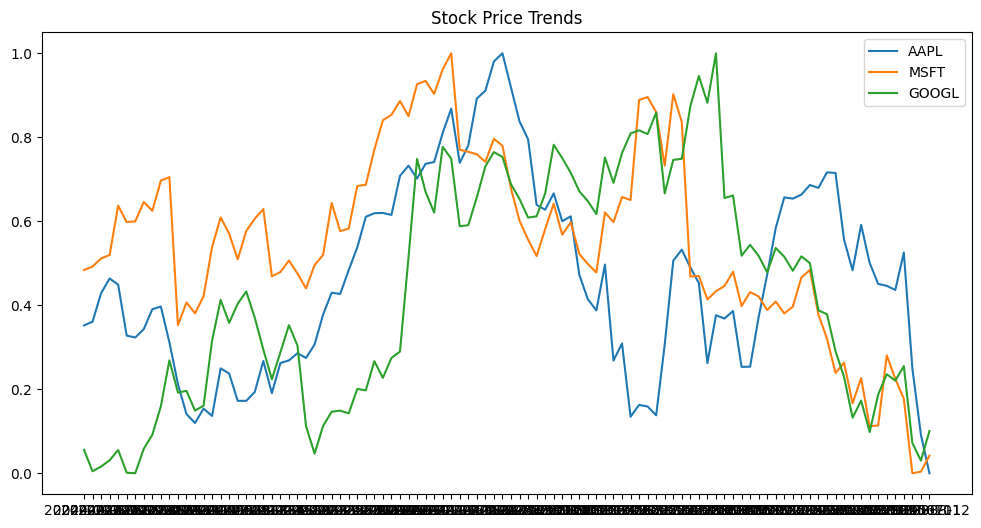

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
for stock in ["AAPL", "MSFT", "GOOGL"]:
    plt.plot(all_stock_data[stock].index, all_stock_data[stock]["close"], label=stock)
plt.title("Stock Price Trends")
plt.legend()
plt.show()


#Moving Averages (50-Day & 200-Day)

In [26]:
for stock in all_stock_data:
    all_stock_data[stock]["50_MA"] = all_stock_data[stock]["close"].rolling(50).mean()
    all_stock_data[stock]["200_MA"] = all_stock_data[stock]["close"].rolling(200).mean()


#feature engineering

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Function to compute technical indicators
def compute_indicators(df):
    df["Daily Return"] = df["close"].pct_change()
    df["Volatility"] = df["close"].rolling(10).std()
    df["50_MA"] = df["close"].rolling(50).mean()
    df["200_MA"] = df["close"].rolling(200).mean()
    
    # Compute Relative Strength Index (RSI)
    delta = df["close"].diff()
    gain = (delta.where(delta > 0, 0)).rolling(14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
    rs = gain / loss
    df["RSI"] = 100 - (100 / (1 + rs))
    
    df.dropna(inplace=True)  # Remove NaN values
    return df

# Select a stock for visualization (e.g., AAPL)
stock = "AAPL"
df = all_stock_data[stock].copy()
df = compute_indicators(df)


In [ ]:
stocks = ["AAPL", "GOOGL", "TSLA", "MSFT"]
for stock in stocks:
    fetch_stock_data(stock, save_csv=True)

# Load AAPL data for EDA
df = fetch_stock_data("AAPL")

# Convert index to datetime
df.index = pd.to_datetime(df.index)

# Display basic info
print(df.info())
print("\nSummary Statistics:\n", df.describe())
print("\nMissing Values:\n", df.isnull().sum())


{'Meta Data': {'1. Information': 'Daily Prices (open, high, low, close) and Volumes', '2. Symbol': 'AAPL', '3. Last Refreshed': '2025-02-18', '4. Output Size': 'Compact', '5. Time Zone': 'US/Eastern'}, 'Time Series (Daily)': {'2025-02-18': {'1. open': '244.1500', '2. high': '245.1800', '3. low': '241.8400', '4. close': '244.4700', '5. volume': '48822491'}, '2025-02-14': {'1. open': '241.2500', '2. high': '245.5500', '3. low': '240.9900', '4. close': '244.6000', '5. volume': '40896227'}, '2025-02-13': {'1. open': '236.9100', '2. high': '242.3399', '3. low': '235.5700', '4. close': '241.5300', '5. volume': '53614054'}, '2025-02-12': {'1. open': '231.2000', '2. high': '236.9600', '3. low': '230.6800', '4. close': '236.8700', '5. volume': '45243292'}, '2025-02-11': {'1. open': '228.2000', '2. high': '235.2300', '3. low': '228.1300', '4. close': '232.6200', '5. volume': '53718362'}, '2025-02-10': {'1. open': '229.5700', '2. high': '230.5850', '3. low': '227.2000', '4. close': '227.6500', '5

In [ ]:
print(all_stocks_df.head())    # View first 5 rows
print(all_stocks_df.info())    # Data types & memory usage
print(all_stocks_df.describe())  # Summary statistics
print(all_stocks_df.isnull().sum())  # Check for missing values


                       Date        Open        High         Low       Close  \
0 2024-02-12 00:00:00-05:00  187.534482  187.783307  185.912138  186.270447   
1 2024-02-13 00:00:00-05:00  184.896945  185.334879  182.647556  184.170364   
2 2024-02-14 00:00:00-05:00  184.449061  184.658065  181.582591  183.284546   
3 2024-02-15 00:00:00-05:00  182.687385  183.622970  180.497727  182.995926   
4 2024-02-16 00:00:00-05:00  182.557985  183.981273  180.816210  181.453201   

     Volume  Dividends  Stock Splits Symbol  Daily Return  20-day MA  \
0  41781900        0.0           0.0   AAPL           NaN        NaN   
1  56529500        0.0           0.0   AAPL     -0.011274        NaN   
2  54630500        0.0           0.0   AAPL     -0.004810        NaN   
3  65434500        0.0           0.0   AAPL     -0.001575        NaN   
4  49701400        0.0           0.0   AAPL     -0.008430        NaN   

   50-day MA  Volatility  
0        NaN         NaN  
1        NaN         NaN  
2        Na

In [ ]:
print(all_stocks_df.duplicated().sum())  #checking for duplicate rows


0


# Time-Series Trend Analysis
# stock trend over time

In [ ]:
import plotly.express as px

fig = px.line(all_stocks_df, x="Date", y="Close", color="Symbol",
              title="Stock Prices of Top 50 Stocks Over Time")
fig.show()
# as it is clumzy and unclear lateron we took top 10 stocks

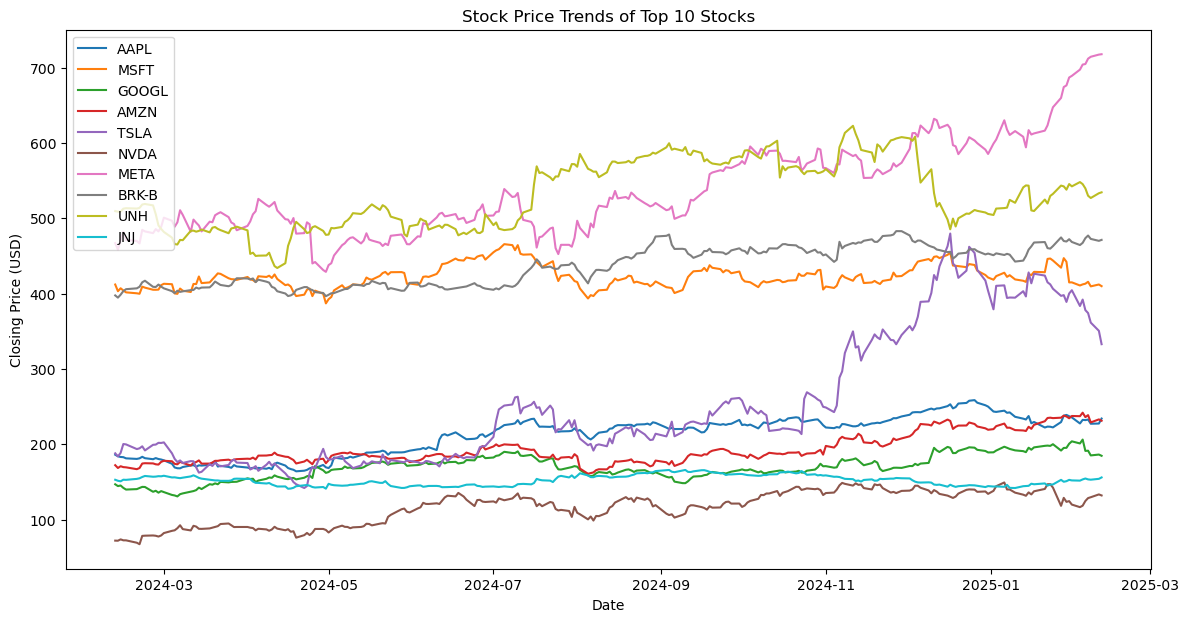

In [ ]:
plt.figure(figsize=(14, 7))
for stock in top_50_stocks[:10]:  # Limit to 10 stocks for readability
    stock_df = all_stocks_df[all_stocks_df["Symbol"] == stock]
    plt.plot(stock_df["Date"], stock_df["Close"], label=stock)

plt.xlabel("Date")
plt.ylabel("Closing Price (USD)")
plt.title("Stock Price Trends of Top 10 Stocks")
plt.legend()
plt.show()


In [ ]:
#Daily Returns Calculation

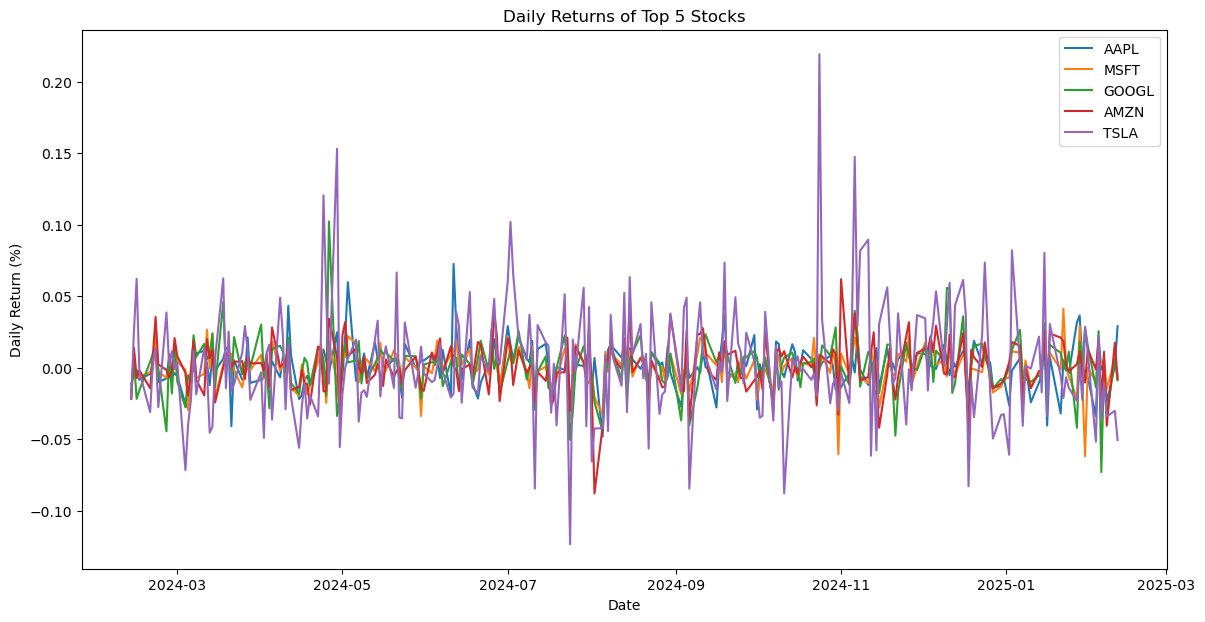

In [ ]:
all_stocks_df["Daily Return"] = all_stocks_df.groupby("Symbol")["Close"].pct_change()

# Plot daily returns for a sample of 5 stocks
plt.figure(figsize=(14, 7))
for stock in top_50_stocks[:5]:  
    stock_df = all_stocks_df[all_stocks_df["Symbol"] == stock]
    plt.plot(stock_df["Date"], stock_df["Daily Return"], label=stock)

plt.xlabel("Date")
plt.ylabel("Daily Return (%)")
plt.title("Daily Returns of Top 5 Stocks")
plt.legend()
plt.show()


In [ ]:
#Distribution of daily returns (volatility analysis)

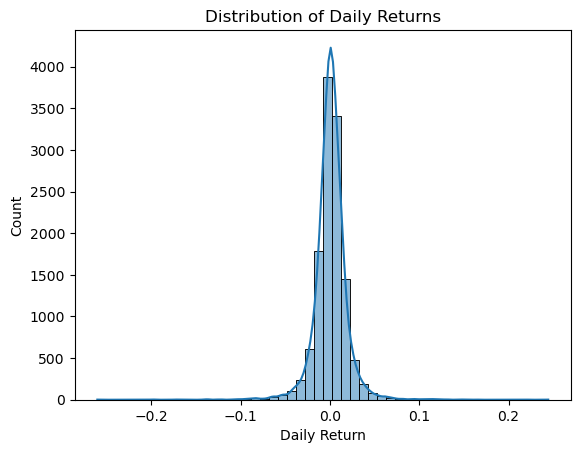

In [ ]:
sns.histplot(all_stocks_df["Daily Return"].dropna(), bins=50, kde=True)
plt.title("Distribution of Daily Returns")
plt.show()

"""X-axis (Horizontal) → Daily Returns

Represents the percentage change in stock price per day.
Values close to 0 indicate small daily price movements.
Positive values (>0) show profitable days.
Negative values (<0) indicate loss-making days.

Y-axis (Vertical) → Frequency (Count)
Shows how often each range of daily returns occurred.
Higher bars indicate common daily return values.
Lower bars indicate less frequent daily return values.

KDE (Smooth Line)
Represents the probability density function (PDF) of daily returns.
Helps visualize the general shape of the distribution."""

In [ ]:
#Moving Averages for Trend Analysis

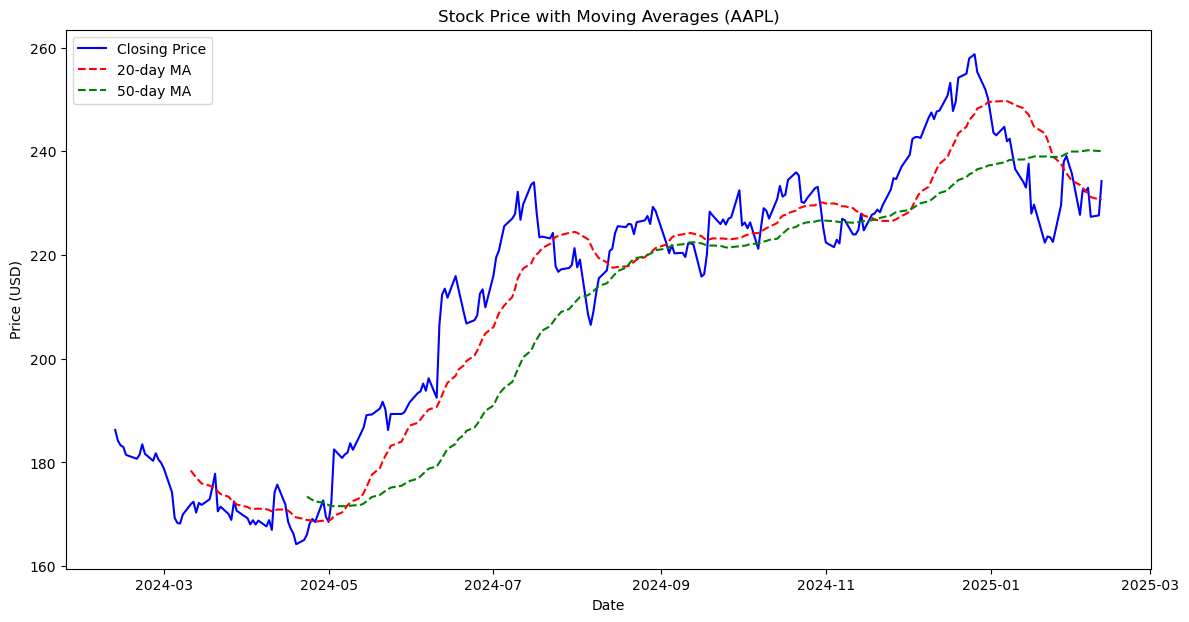

In [ ]:
all_stocks_df["20-day MA"] = all_stocks_df.groupby("Symbol")["Close"].transform(lambda x: x.rolling(window=20).mean())
all_stocks_df["50-day MA"] = all_stocks_df.groupby("Symbol")["Close"].transform(lambda x: x.rolling(window=50).mean())

""" groupby("Symbol"): Groups the dataframe by stock ticker symbols (i.e., separate calculations for each stock).
    Close: Refers to the daily closing price of each stock.
    rolling(window=20).mean(): Computes the 20-day simple moving average (SMA).
    rolling(window=50).mean(): Computes the 50-day SMA.
    transform(...): Ensures the calculated values are stored in the original DataFrame, keeping all columns intact."""

sample_stock = "AAPL"  #takeing apple stock as example
sample_df = all_stocks_df[all_stocks_df["Symbol"] == sample_stock]

plt.figure(figsize=(14, 7))
plt.plot(sample_df["Date"], sample_df["Close"], label="Closing Price", color="blue")
plt.plot(sample_df["Date"], sample_df["20-day MA"], label="20-day MA", linestyle="--", color="red")
plt.plot(sample_df["Date"], sample_df["50-day MA"], label="50-day MA", linestyle="--", color="green")

plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.title(f"Stock Price with Moving Averages ({sample_stock})")
plt.legend()
plt.show()



In [ ]:
#Correlation Analysis Between Stocks

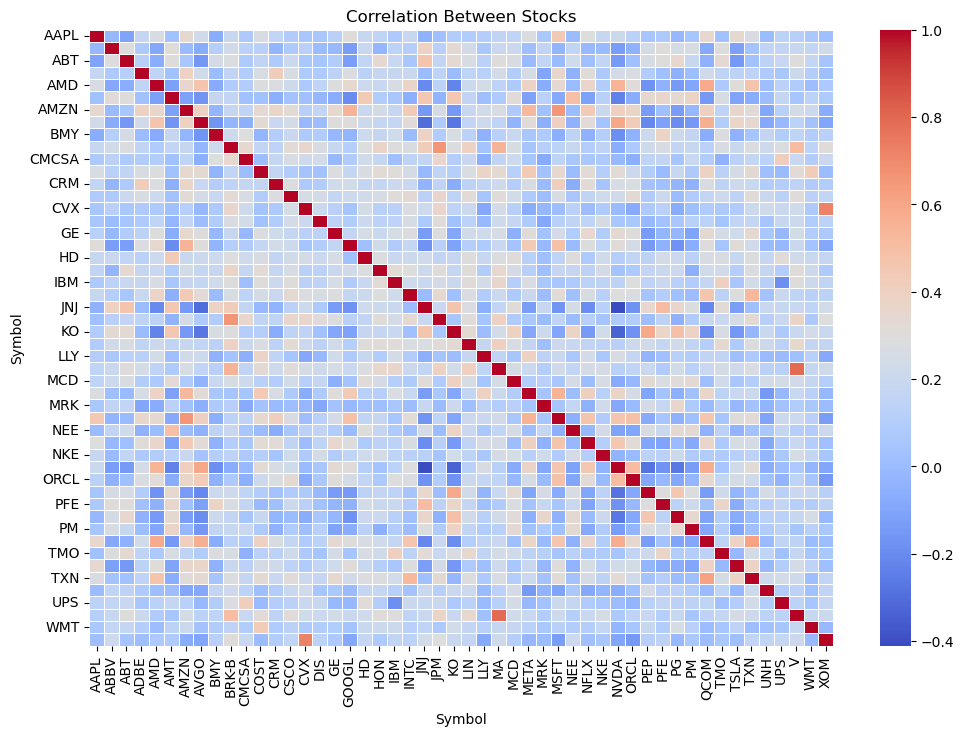

In [ ]:
returns_df = all_stocks_df.pivot(index="Date", columns="Symbol", values="Daily Return")
correlation_matrix = returns_df.corr()

# Heatmap of stock correlations
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Between Stocks")
plt.show()


In [ ]:
#Volatility Analysis
#Risk Assessment: High volatility = higher risk (and potentially higher returns).

In [ ]:
#Volatility Analysis (Standard Deviation)
#Stocks with higher volatility (fluctuations in price) are riskier.

In [ ]:
# Compute rolling standard deviation (volatility)
all_stocks_df["Volatility"] = all_stocks_df.groupby("Symbol")["Daily Return"].transform(lambda x: x.rolling(window=30).std())

# Identify top 10 most volatile stocks
high_risk_stocks = all_stocks_df.groupby("Symbol")["Volatility"].mean().nlargest(10)
print(high_risk_stocks)


Symbol
TSLA    0.040585
AVGO    0.034203
NVDA    0.033239
INTC    0.030629
AMD     0.028729
QCOM    0.023646
CRM     0.021770
ADBE    0.021732
ORCL    0.021242
GE      0.020118
Name: Volatility, dtype: float64


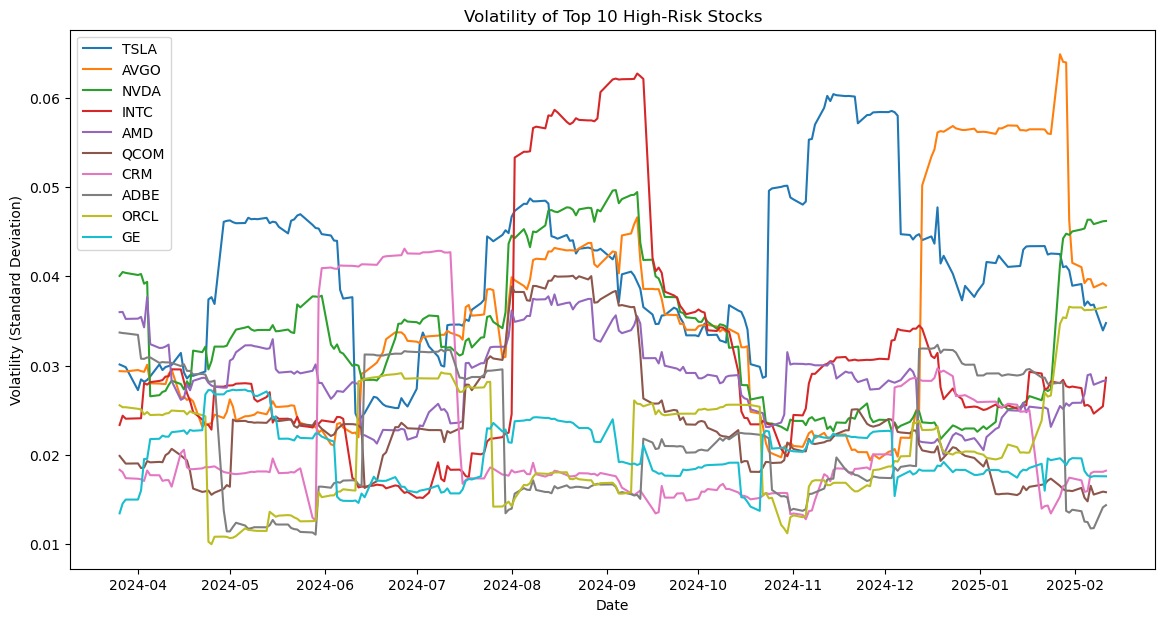

In [ ]:
plt.figure(figsize=(14, 7))
for stock in high_risk_stocks.index:
    stock_df = all_stocks_df[all_stocks_df["Symbol"] == stock]
    plt.plot(stock_df["Date"], stock_df["Volatility"], label=stock)

plt.xlabel("Date")
plt.ylabel("Volatility (Standard Deviation)")
plt.title("Volatility of Top 10 High-Risk Stocks")
plt.legend()
plt.show()
    

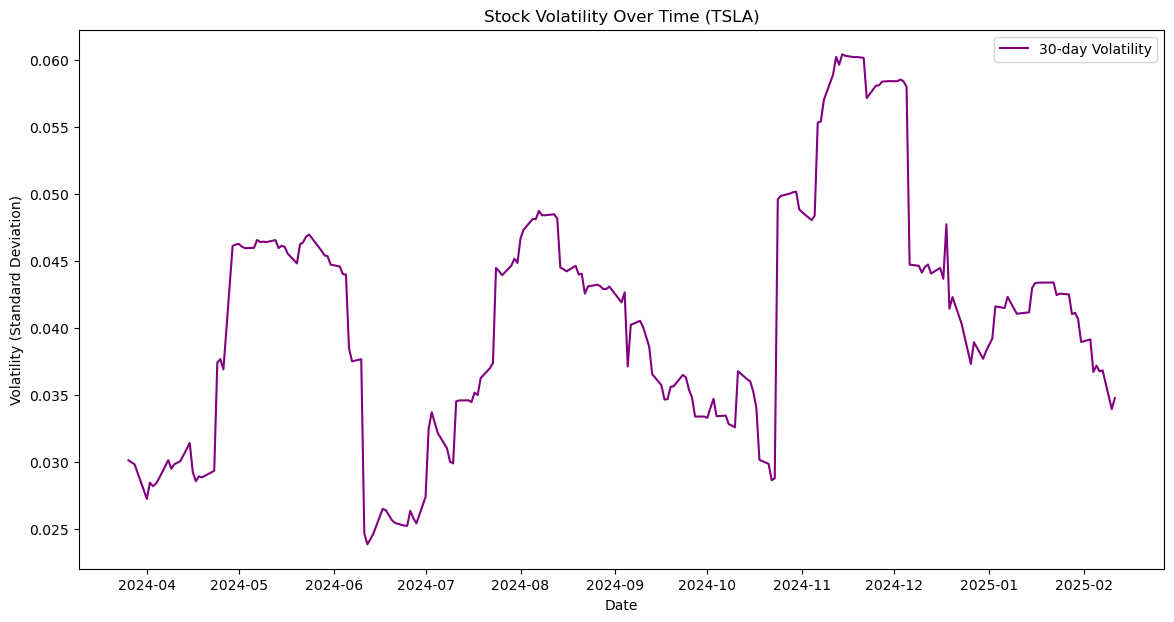

In [ ]:
# Calculate 30-day rolling standard deviation (Volatility)
all_stocks_df["Volatility"] = all_stocks_df.groupby("Symbol")["Daily Return"].transform(lambda x: x.rolling(window=30).std())

# Now filter for the sample stock AFTER volatility is created
sample_stock = "TSLA"
sample_df = all_stocks_df[all_stocks_df["Symbol"] == sample_stock]


if "Volatility" in sample_df.columns:
    plt.figure(figsize=(14, 7))
    plt.plot(sample_df["Date"], sample_df["Volatility"], label="30-day Volatility", color="purple")
    plt.xlabel("Date")
    plt.ylabel("Volatility (Standard Deviation)")
    plt.title(f"Stock Volatility Over Time ({sample_stock})")
    plt.legend()
    plt.show()
else:
    print("Error: 'Volatility' column not found in sample_df")



In [ ]:
# Volume Analysis

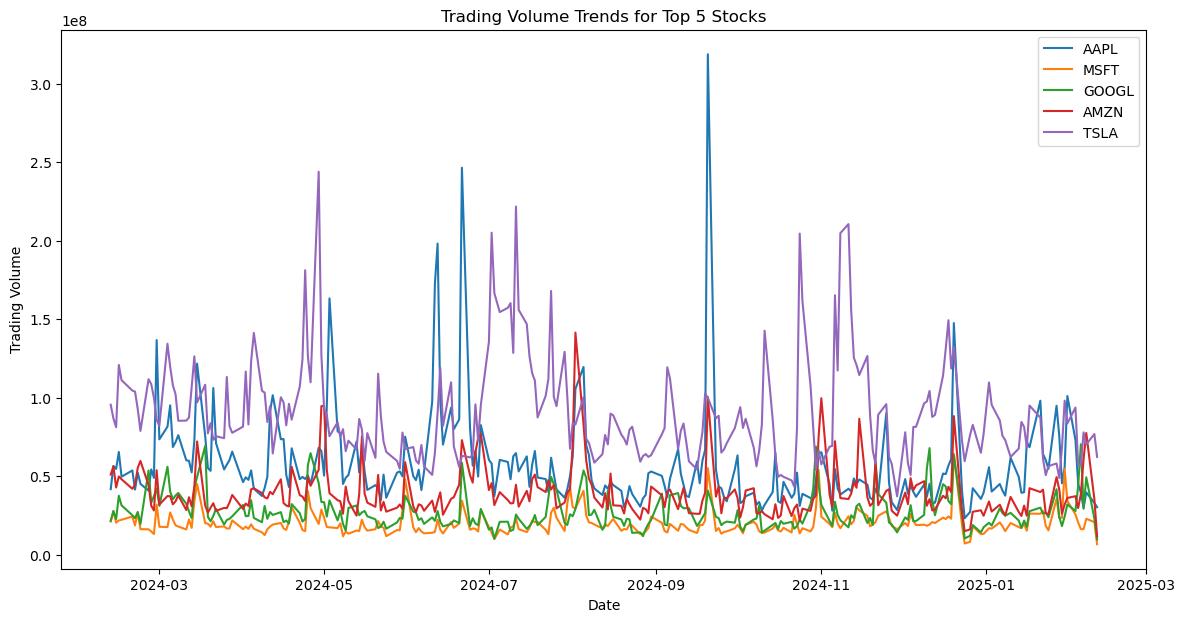

In [ ]:
plt.figure(figsize=(14, 7))
for stock in top_50_stocks[:5]:  
    stock_df = all_stocks_df[all_stocks_df["Symbol"] == stock]
    plt.plot(stock_df["Date"], stock_df["Volume"], label=stock)

plt.xlabel("Date")
plt.ylabel("Trading Volume")
plt.title("Trading Volume Trends for Top 5 Stocks")
plt.legend()
plt.show()


# X-axis: "Date" → Represents the timeline.
# Y-axis: "Trading Volume" → Represents how many shares were traded.

In [ ]:
#Outlier Detection (Using Boxplots)

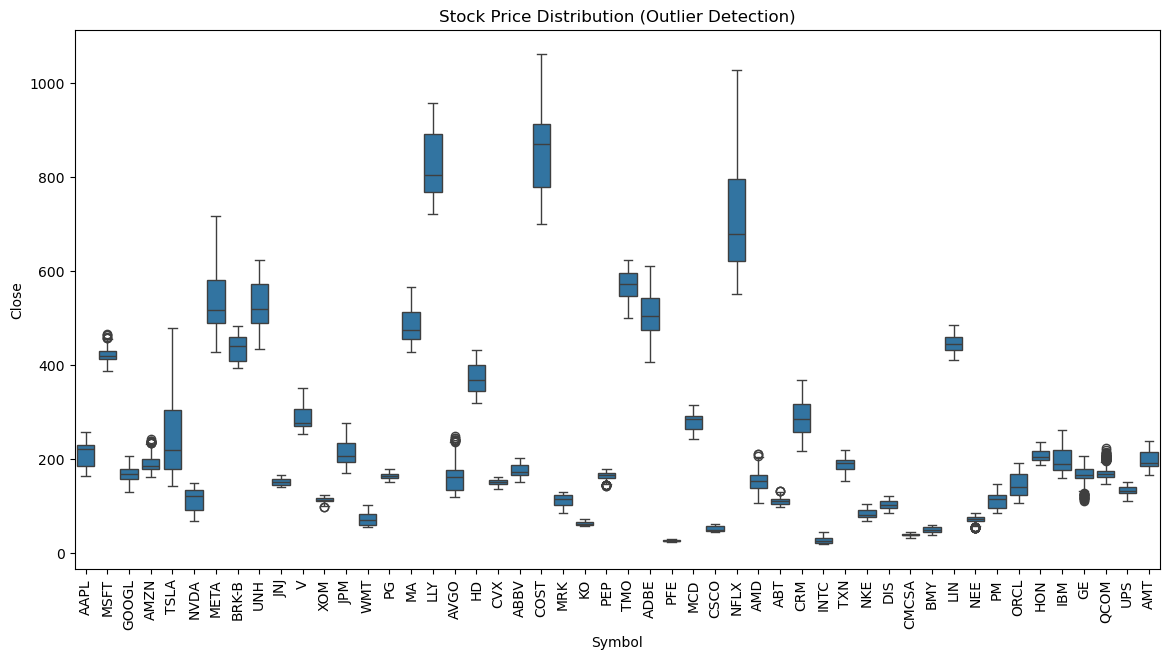

In [ ]:
plt.figure(figsize=(14, 7))
sns.boxplot(x="Symbol", y="Close", data=all_stocks_df)
plt.xticks(rotation=90)
plt.title("Stock Price Distribution (Outlier Detection)")
plt.show()


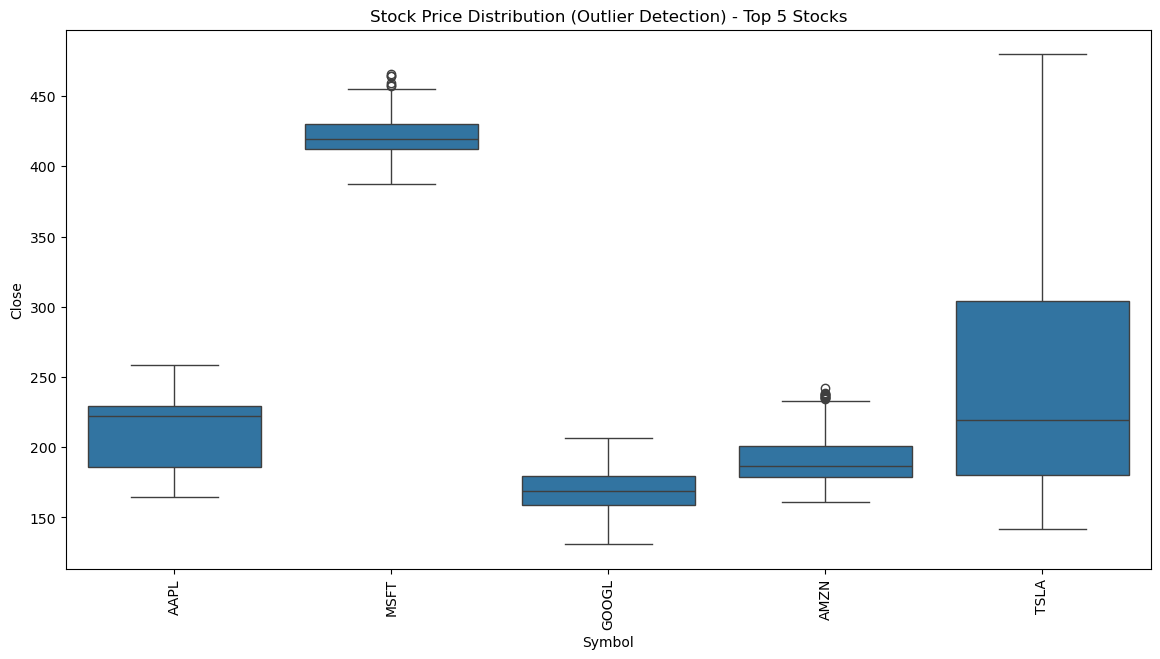

In [ ]:
plt.figure(figsize=(14, 7))

# Filter data for the top 5 stocks
top_5_stocks = top_50_stocks[:5]  # Assuming you already have 'top_50_stocks' list
filtered_df = all_stocks_df[all_stocks_df["Symbol"].isin(top_5_stocks)]

# Create boxplot for the top 5 stocks
sns.boxplot(x="Symbol", y="Close", data=filtered_df)

# Formatting
plt.xticks(rotation=90)
plt.title("Stock Price Distribution (Outlier Detection) - Top 5 Stocks")
plt.show()


In [ ]:
#modeling

In [ ]:
pip install pandas numpy requests tensorflow scikit-learn fastapi uvicorn alpha_vantage


  Using cached h11-0.14.0-py3-none-any.whl.metadata (8.2 kB)
   ---------------------------------------- 0.0/94.8 kB ? eta -:--:--
   -------------------------------------- - 92.2/94.8 kB 2.6 MB/s eta 0:00:01
   ---------------------------------------- 94.8/94.8 kB 1.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/62.3 kB ? eta -:--:--
   ---------------------------------------- 62.3/62.3 kB 3.3 MB/s eta 0:00:00
Using cached h11-0.14.0-py3-none-any.whl (58 kB)
   ---------------------------------------- 0.0/71.5 kB ? eta -:--:--
   ---------------------------------------- 71.5/71.5 kB 4.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [ ]:

from alpha_vantage.timeseries import TimeSeries

# Alpha Vantage API Key
API_KEY = "QA0H6XLQD3TVABT5"

# Fetch Stock Data
def fetch_stock_data(symbol, interval="daily", output_size="full"):
    ts = TimeSeries(key=API_KEY, output_format="pandas")
    if interval == "daily":
        data, meta_data = ts.get_daily(symbol=symbol, outputsize=output_size)
    elif interval == "intraday":
        data, meta_data = ts.get_intraday(symbol=symbol, interval="15min", outputsize=output_size)
    else:
        raise ValueError("Invalid interval")

    # Rename columns
    data.columns = ["Open", "High", "Low", "Close", "Volume"]
    data = data[::-1]  # Reverse to have oldest first
    data.reset_index(inplace=True)
    return data

# Example: Fetch Apple Stock Data
symbol = "AAPL"
df = fetch_stock_data(symbol)
print(df.head())


In [ ]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pickle

# Load stock data
df = pd.read_csv("data/all_stocks_data.csv")

# Split data into training and test sets (e.g., 80% training, 20% testing)
train_df, test_df = train_test_split(df, test_size=0.2, shuffle=False)

# Preprocess data
scaler = MinMaxScaler(feature_range=(0, 1))
train_df["close_scaled"] = scaler.fit_transform(train_df["close"].values.reshape(-1, 1))
test_df["close_scaled"] = scaler.transform(test_df["close"].values.reshape(-1, 1))

# Create sequences for LSTM
def create_sequences(data, seq_length=50):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i : i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 50
X_train, y_train = create_sequences(train_df["close_scaled"].values, seq_length)
X_test, y_test = create_sequences(test_df["close_scaled"].values, seq_length)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Build LSTM Model
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(0.2),
    LSTM(units=50, return_sequences=False),
    Dropout(0.2),
    Dense(units=25),
    Dense(units=1)
])

model.compile(optimizer="adam", loss="mean_squared_error")
model.fit(X_train, y_train, epochs=10, batch_size=32)

# Save the trained model in Keras format
model.save("models/lstm_model.keras")
print("LSTM Model trained and saved in Keras format!")

# Make predictions on the test set
predicted_scaled = model.predict(X_test)

# Inverse transform the predictions to get actual stock prices
predicted_prices = scaler.inverse_transform(predicted_scaled)

# Compare with actual prices
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

# Create a DataFrame to compare actual and predicted prices
results_df = pd.DataFrame({
    'Actual Price': actual_prices.flatten(),
    'Predicted Price': predicted_prices.flatten()
})

print(results_df)


Epoch 1/10


c:\Users\ronga\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - loss: 0.0162
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0049
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0040
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0040
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0040
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0026
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0040
Epoch 8/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0020
Epoch 9/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0031
Epoch 10/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0016
LSTM Model trained and saved in Keras format!
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
     Actual Price  Predicted Price
0          427.19       382.729767
1          429.13       386.623322
2          426.96       389.188751
3          429.35       389.927155
4          427.92       390.158997
..            ...              ...
445         24.47  

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate evaluation metrics
mae = mean_absolute_error(results_df['Actual Price'], results_df['Predicted Price'])
mse = mean_squared_error(results_df['Actual Price'], results_df['Predicted Price'])
rmse = np.sqrt(mse)
r2 = r2_score(results_df['Actual Price'], results_df['Predicted Price'])

# Print the metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")

Mean Absolute Error (MAE): 21.333597829204137
Mean Squared Error (MSE): 914.2814179569759
Root Mean Squared Error (RMSE): 30.237086796796017
R-squared (R²): 0.9314586022441868


In [ ]:
print(results_df.columns)

Index(['Actual Price', 'Predicted Price'], dtype='object')


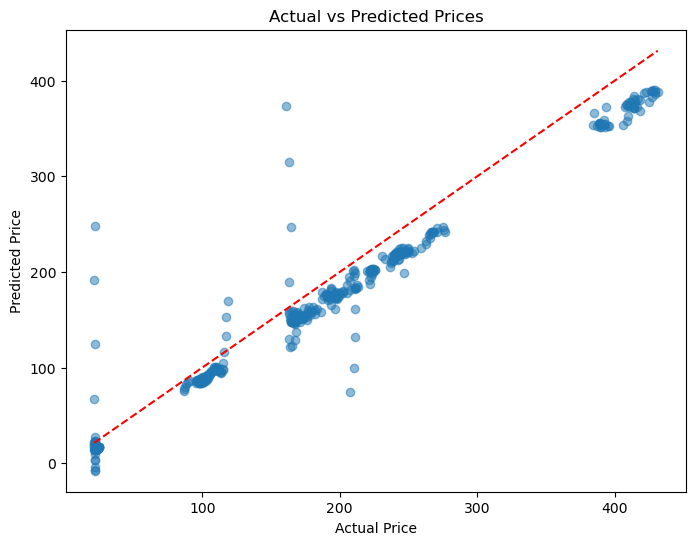

KeyError: 'Date'

<Figure size 1200x600 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

# Scatter plot of actual vs predicted prices
plt.figure(figsize=(8, 6))
plt.scatter(results_df['Actual Price'], results_df['Predicted Price'], alpha=0.5)
plt.plot([min(results_df['Actual Price']), max(results_df['Actual Price'])], 
         [min(results_df['Actual Price']), max(results_df['Actual Price'])], 
         color='red', linestyle='--')  # Diagonal line for perfect predictions
plt.title("Actual vs Predicted Prices")
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.show()

# Line plot of actual vs predicted prices over time
plt.figure(figsize=(12, 6))
plt.plot(results_df['Date'], results_df['Actual Price'], label='Actual Price', color='blue')
plt.plot(results_df['Date'], results_df['Predicted Price'], label='Predicted Price', color='red', linestyle='--')
plt.title("Stock Price Prediction: Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [ ]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
import pickle

# Load stock data
df = pd.read_csv("data/all_stocks_data.csv")

# Preprocess data
scaler = MinMaxScaler(feature_range=(0, 1))
df["close_scaled"] = scaler.fit_transform(df["close"].values.reshape(-1, 1))

#  Create models directory if it doesn't exist
os.makedirs("models", exist_ok=True)

# Save the scaler
with open("models/scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

# Create sequences for LSTM
def create_sequences(data, seq_length=50):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i : i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 50
X, y = create_sequences(df["close_scaled"].values, seq_length)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Build LSTM Model
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(0.2),
    LSTM(units=50, return_sequences=False),
    Dropout(0.2),
    Dense(units=25),
    Dense(units=1)
])

model.compile(optimizer="adam", loss="mean_squared_error")
model.fit(X, y, epochs=10, batch_size=32)

#firsst we tried doing in HDF5 (.h5) hirrarichal data format.

# Save the trained model in Keras format (best for cloud deployment)
model.save("models/lstm_model.keras")
print(" LSTM Model trained and saved in Keras format (best for Docker & Kubernetes)!")



Epoch 1/10


c:\Users\ronga\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


77/77 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - loss: 0.0143
Epoch 2/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0051
Epoch 3/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0041
Epoch 4/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0028
Epoch 5/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0026
Epoch 6/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0030
Epoch 7/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.0033
Epoch 8/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0021
Epoch 9/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0022
Epoch 10/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0020
 LSTM Model trained and saved in Keras format (best for Docker & Kubernetes)!


In [ ]:
print(df_pred['date'])

0      1970-01-01 00:00:00.000000050
1      1970-01-01 00:00:00.000000051
2      1970-01-01 00:00:00.000000052
3      1970-01-01 00:00:00.000000053
4      1970-01-01 00:00:00.000000054
                    ...             
2445   1970-01-01 00:00:00.000002495
2446   1970-01-01 00:00:00.000002496
2447   1970-01-01 00:00:00.000002497
2448   1970-01-01 00:00:00.000002498
2449   1970-01-01 00:00:00.000002499
Name: date, Length: 2450, dtype: datetime64[ns]


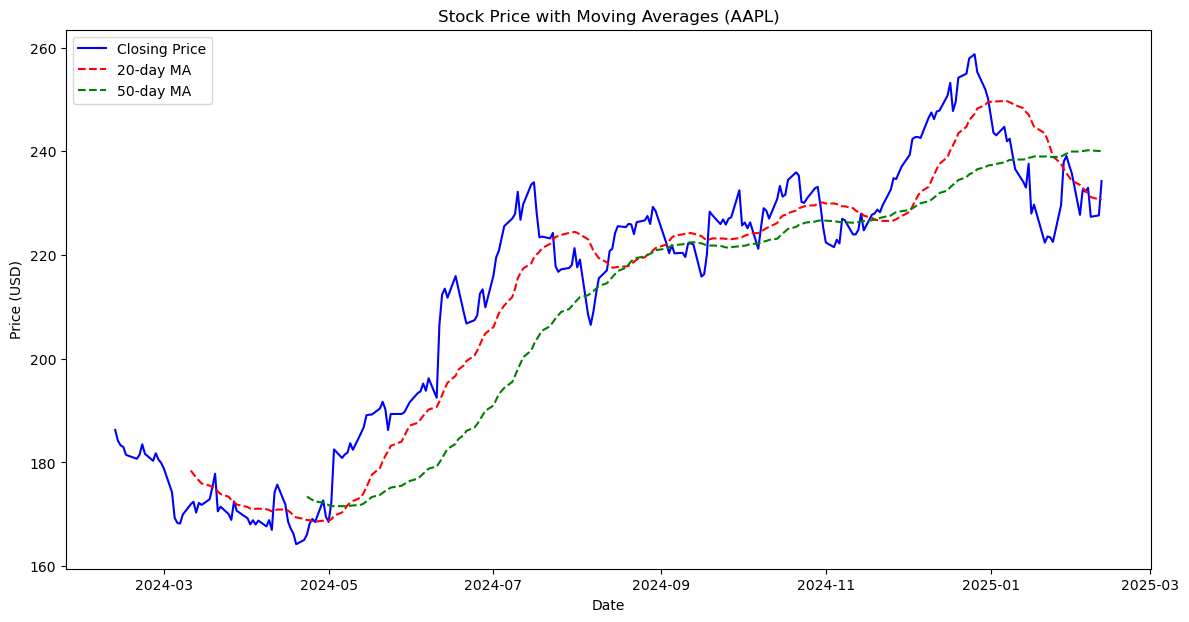

In [ ]:
all_stocks_df["20-day MA"] = all_stocks_df.groupby("Symbol")["Close"].transform(lambda x: x.rolling(window=20).mean())
all_stocks_df["50-day MA"] = all_stocks_df.groupby("Symbol")["Close"].transform(lambda x: x.rolling(window=50).mean())

# Plot Moving Averages for a sample stock
sample_stock = "AAPL"
sample_df = all_stocks_df[all_stocks_df["Symbol"] == sample_stock]

plt.figure(figsize=(14, 7))
plt.plot(sample_df["Date"], sample_df["Close"], label="Closing Price", color="blue")
plt.plot(sample_df["Date"], sample_df["20-day MA"], label="20-day MA", linestyle="--", color="red")
plt.plot(sample_df["Date"], sample_df["50-day MA"], label="50-day MA", linestyle="--", color="green")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.title(f"Stock Price with Moving Averages ({sample_stock})")
plt.legend()
plt.show()


In [ ]:
import plotly.express as px

stock_prices['Date'] = stock_prices.index
fig = px.line(stock_prices, x='Date', y=stocks, 
              title="Stock Price Fluctuations of AAPL, GOOGL, TSLA, MSFT",
              labels={"value": "Stock Price (USD)", "Date": "Date"})
fig.show()


#Moving Average (Short-term & Long-term)

#Daily Returns Distribution

# Volatility (Rolling Standard Deviation)

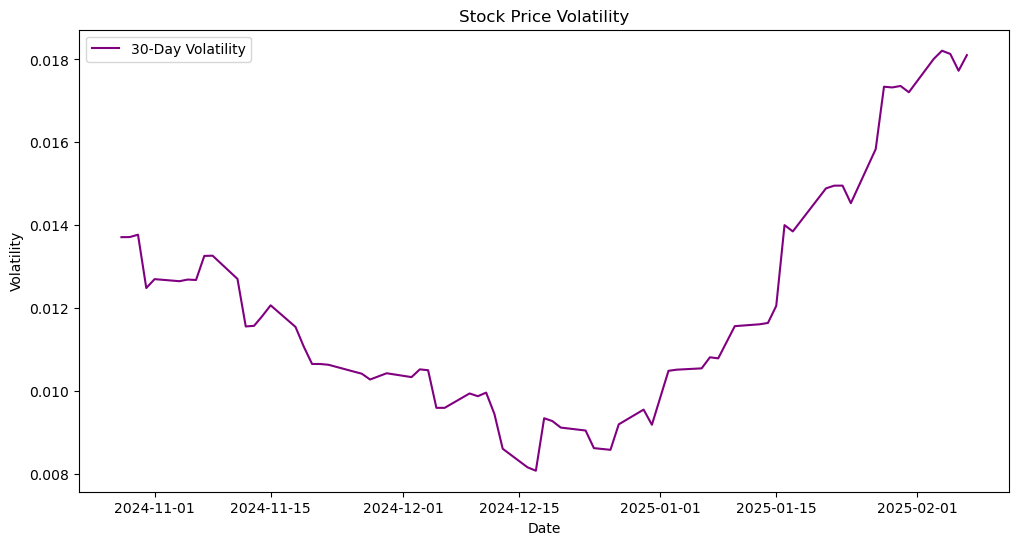

In [ ]:
df["volatility"] = df["daily_return"].rolling(window=30).std()
plt.figure(figsize=(12, 6))
plt.plot(df["volatility"], label="30-Day Volatility", color='purple')
plt.title("Stock Price Volatility")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# List of stocks
stocks = ["AAPL", "GOOGL", "TSLA", "MSFT"]

# Function to prepare stock data
def prepare_data(symbol):
    df = fetch_stock_data(symbol)  # Fetch data
    scaler = MinMaxScaler(feature_range=(0, 1))  # Normalize
    scaled_data = scaler.fit_transform(df[['close']])
    
    # Create sequences
    def create_sequences(data, time_step=60):
        X, y = [], []
        for i in range(len(data) - time_step):
            X.append(data[i:i + time_step])
            y.append(data[i + time_step])
        return np.array(X), np.array(y)

    time_step = 60
    X, y = create_sequences(scaled_data, time_step)
    train_size = int(len(X) * 0.8)

    return X[:train_size], X[train_size:], y[:train_size], y[train_size:], scaler, df.index[-len(y[train_size:]):]



In [ ]:
# Function to create and train an LSTM model
def train_lstm(X_train, y_train, X_test, y_test):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(25),
        Dense(1)
    ])
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=300, batch_size=32, validation_data=(X_test, y_test), verbose=0)
    
    return model


In [ ]:
predictions = {}

for stock in stocks:
    print(f"Training LSTM for {stock}...")
    
    # Prepare data
    X_train, X_test, y_train, y_test, scaler, dates = prepare_data(stock)

    # Train model
    model = train_lstm(X_train, y_train, X_test, y_test)

    # Predict
    pred = model.predict(X_test)
    predictions[stock] = (scaler.inverse_transform(pred), scaler.inverse_transform(y_test.reshape(-1,1)), dates)


Training LSTM for AAPL...
             1. open   2. high    3. low  4. close  5. volume
2025-02-07  232.6000  234.0000  227.2600  227.6300   39707224
2025-02-06  231.2850  233.8000  230.4250  233.2200   29925349
2025-02-05  228.5300  232.6700  228.2700  232.4700   39664989
2025-02-04  227.2500  233.1300  226.6500  232.8000   45067301
2025-02-03  229.9900  231.8300  225.7000  228.0100   73063301
...              ...       ...       ...       ...        ...
2024-09-20  229.9700  233.0900  227.6200  228.2000  318679888
2024-09-19  224.9900  229.8200  224.6300  228.8700   66781315
2024-09-18  217.5500  222.7100  217.5400  220.6900   59894928
2024-09-17  215.7500  216.9000  214.5000  216.7900   45519339
2024-09-16  216.5400  217.2200  213.9200  216.3200   59357427

[100 rows x 5 columns]
sree


c:\Users\ronga\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
Training LSTM for GOOGL...
             1. open   2. high    3. low  4. close 5. volume
2025-02-07  191.0500  191.1800  183.2400  185.3400  49314961
2025-02-06  189.5000  192.1000  188.7200  191.6000  29297442
2025-02-05  191.0700  192.7500  188.0300  191.3300  70461770
2025-02-04  203.3900  207.0500  202.8100  206.3800  43856425
2025-02-03  200.6900  203.7500  200.1000  201.2300  27838348
...              ...       ...       ...       ...       ...
2024-09-20  163.5000  163.7300  162.0600  163.5900  40896438
2024-09-19  163.7100  163.7900  161.3400  162.1400  26587733
2024-09-18  159.8600  160.5000  158.5950  159.8100  23677315
2024-09-17  159.0200  160.5500  158.3750  159.3200  20715612
2024-09-16  157.3100  158.2500  156.6000  158.0600  18379775

[100 rows x 5 columns]
sree


c:\Users\ronga\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step
Training LSTM for TSLA...
             1. open   2. high    3. low  4. close  5. volume
2025-02-07  370.1900  380.5459  360.3400  361.6200   70298258
2025-02-06  373.0300  375.4000  363.1800  374.3200   77918230
2025-02-05  387.5100  388.3900  375.5300  378.1700   57614721
2025-02-04  382.6300  394.0000  381.4000  392.2100   57072235
2025-02-03  386.6800  389.1700  374.3600  383.6800   93732122
...              ...       ...       ...       ...        ...
2024-09-20  241.5200  243.9900  235.9200  238.2500   99879070
2024-09-19  234.0000  244.2400  232.1300  243.9200  102694576
2024-09-18  230.0900  235.6800  226.8800  227.2000   78010204
2024-09-17  229.4500  234.5700  226.5533  227.8700   66761636
2024-09-16  229.3000  229.9600  223.5300  226.7800   54322995

[100 rows x 5 columns]
sree


c:\Users\ronga\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
Training LSTM for MSFT...
             1. open   2. high    3. low  4. close 5. volume
2025-02-07  416.4800  418.6500  408.1000  409.7500  22886844
2025-02-06  414.0000  418.2000  414.0000  415.8200  16309755
2025-02-05  412.3500  413.8270  410.4000  413.2900  16336188
2025-02-04  412.6850  413.9199  409.7400  412.3700  20532096
2025-02-03  411.6000  415.4100  408.6600  410.9200  25679149
...              ...       ...       ...       ...       ...
2024-09-20  437.2200  439.2400  434.2200  435.2700  55167106
2024-09-19  441.2250  441.5000  436.9000  438.6900  21706559
2024-09-18  435.0000  436.0300  430.4100  430.8100  18898042
2024-09-17  440.2300  441.8500  432.2700  435.1500  18874231
2024-09-16  430.6000  433.5300  428.2200  431.3400  13834697

[100 rows x 5 columns]
sree


c:\Users\ronga\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


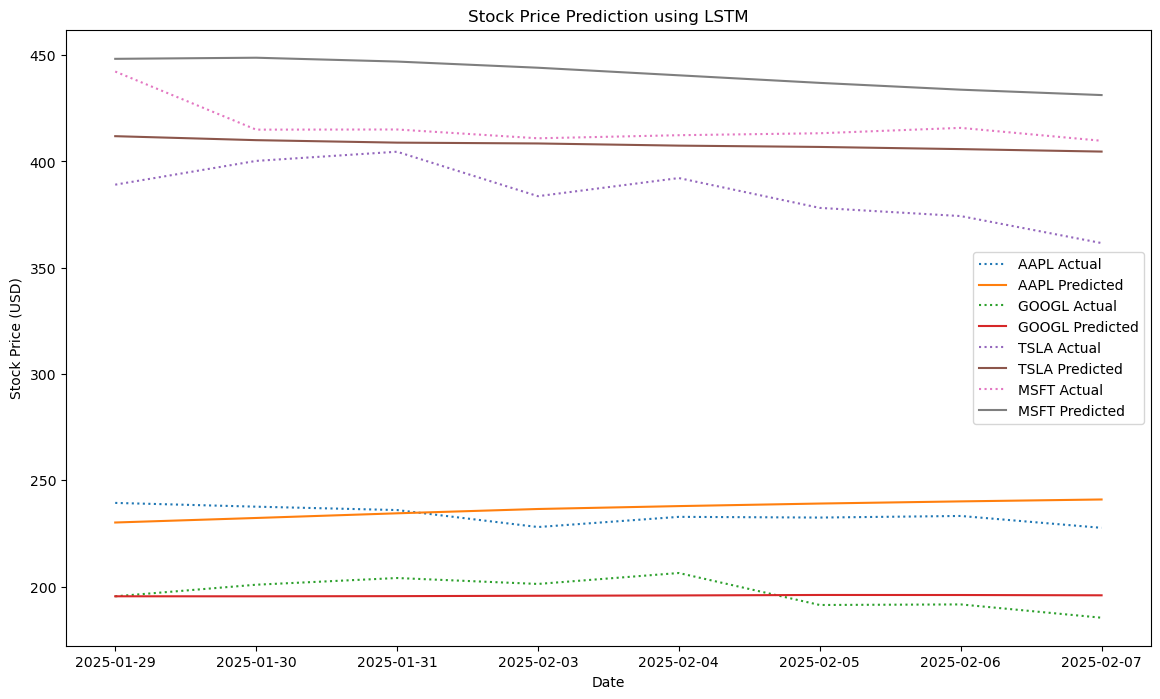

In [ ]:
plt.figure(figsize=(14, 8))

for stock, (pred, actual, dates) in predictions.items():
    plt.plot(dates, actual, label=f"{stock} Actual", linestyle="dotted")
    plt.plot(dates, pred, label=f"{stock} Predicted")

plt.title("Stock Price Prediction using LSTM")
plt.xlabel("Date")
plt.ylabel("Stock Price (USD)")
plt.legend()
plt.show()
 


In [ ]:
#Poor Data Scaling or Transformation
#Issue: If the MinMaxScaler was not fitted properly, all predicted values might be mapped incorrectly, making them constant.


In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_data = scaler.fit_transform(df[['close']])  # Fit only on train
test_data = scaler.transform(df[['close']])  # Transform test separately


In [ ]:
#STM Model Might Be Underfitting
#Issue: If your LSTM model is too shallow (few layers, neurons) or training is too short, it won’t learn well.
#Fix: Increase layers, neurons, and training epochs.

In [ ]:
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(100, return_sequences=False),
    Dropout(0.2),
    Dense(50),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)  # Increase epochs


Epoch 1/50


c:\Users\ronga\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.4763
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.2267
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0955
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0860
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.1180
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.1166
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0916
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0702
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0715
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0738
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0844
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0788
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0839
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0693
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0749
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/st

In [ ]:
#Incorrect Prediction Rescaling
#Issue: The LSTM model predicts normalized values, but if you don’t correctly inverse_transform them back, they look flat.
#Fix: Use scaler.inverse_transform before plottin

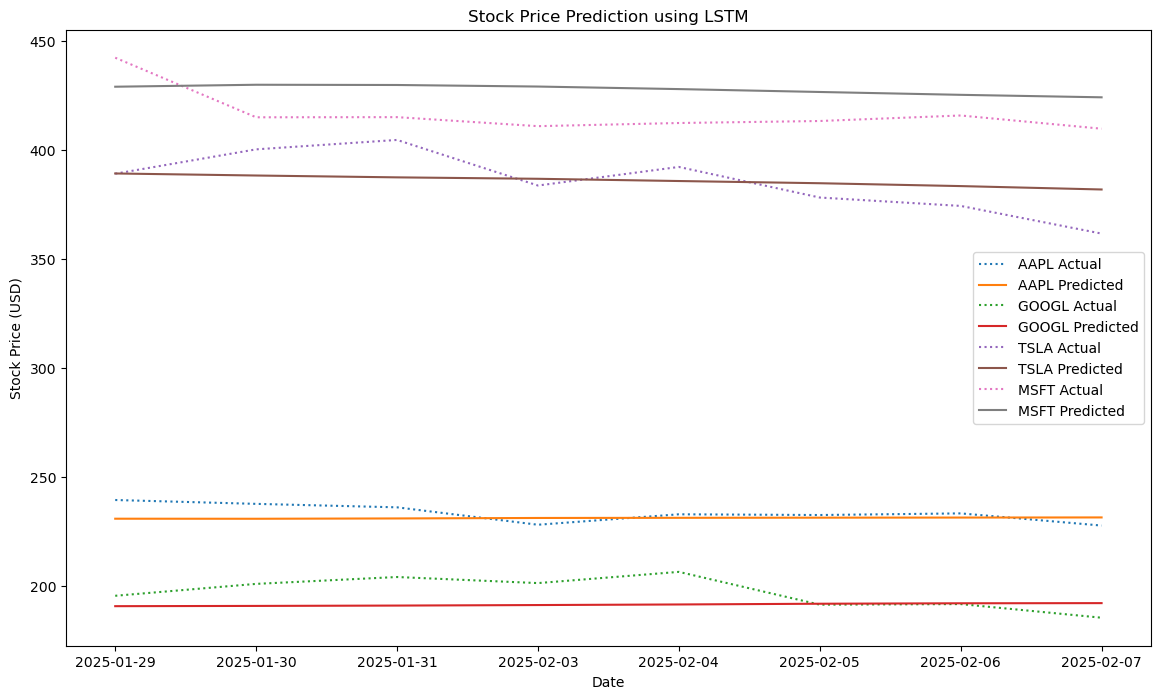

In [ ]:
plt.figure(figsize=(14, 8))

for stock, (pred, actual, dates) in predictions.items():
    plt.plot(dates, actual, label=f"{stock} Actual", linestyle="dotted")
    plt.plot(dates, pred, label=f"{stock} Predicted")

plt.title("Stock Price Prediction using LSTM")
plt.xlabel("Date")
plt.ylabel("Stock Price (USD)")
plt.legend()
plt.show()
